Reproducing Steve's magnetic suppression factor, comparing his functional form to fitted values, and extending to the Bastien 2016 data

In [1]:
from base import *
import scipy as scp

In [2]:
def f(x, Toff, Tscale):
    return 1 / (1 + (x - Toff) / Tscale)

def fit(x, y):
    return scp.optimize.curve_fit(f, x, y, p0=(5400, 1500))

/home/sam/.anaconda3/lib/python3.6/site-packages/scipy/optimize/zeros.py:323: RuntimeWarning: Tolerance of 7.324441342889257e+27 reached
  warnings.warn(msg, RuntimeWarning)


Fit is 1 / (1 + (x - 5281 +/- 9) / 1771 +/- 31)
Steve had 1 / (1 + (x - 5400) / 1500)


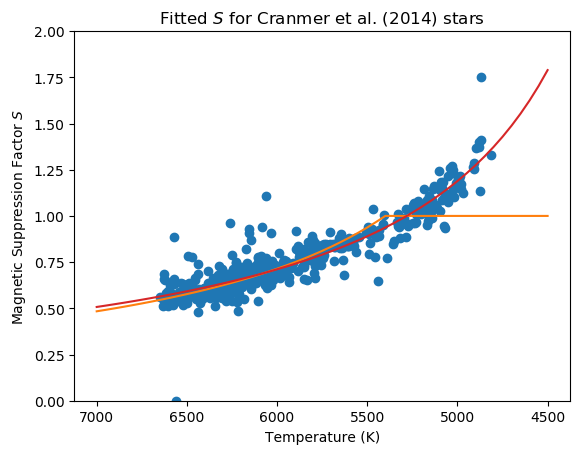

In [3]:
c = catalog[ catalog['has_C'] == 1 ]

S_cran = fit_S(c['loggC'], c['TeffC'], c['MC'], c['F8_obsC'])
scatter_x = c['TeffC']

popt, pcov = fit(scatter_x, S_cran)
perr = np.sqrt(np.diag(pcov))
print(f"Fit is 1 / (1 + (x - {popt[0]:.0f} +/- {perr[0]:.0f}) / {popt[1]:.0f} +/- {perr[1]:.0f})")
print("Steve had 1 / (1 + (x - 5400) / 1500)")

x = np.linspace(4500, 7000, 51)
y = calc_cranmer_S(x)
plt.scatter(scatter_x, S_cran)
plt.plot(x, y, color="C1")
plt.plot(x, f(x, *popt), color="C3")
plt.gca().invert_xaxis()
plt.ylim(0, 2)
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetic Suppression Factor $S$")
plt.title("Fitted $S$ for Cranmer et al. (2014) stars");

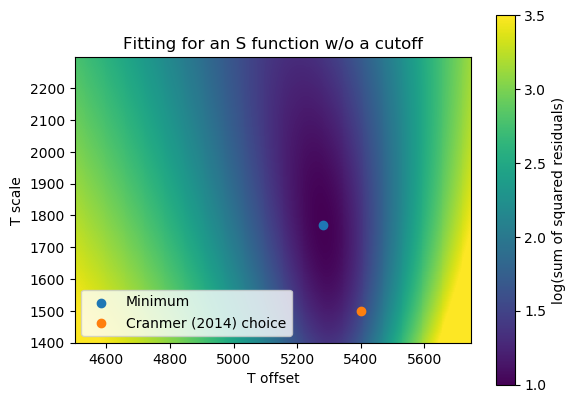

In [4]:
def g(Toff, Tscale):
    return np.sum((f(scatter_x, Toff, Tscale) - S_cran)**2)

Ts = []
sums = []
Toffs = range(4500, 5750, 3)
Tscales = range(1400, 2300, 3)
XX, YY = np.meshgrid(Toffs, Tscales)
vals = np.zeros_like(XX, dtype=np.float)

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        try:
            vals[i,j] = g(XX[i,j], YY[i,j])
        except:
            pass
plt.imshow(np.log(vals), extent=(XX.min(), XX.max(), YY.min(), YY.max()), aspect=1, vmax=3.5, origin='lower')
plt.xlabel("T offset")
plt.ylabel("T scale")
plt.colorbar().set_label("log(sum of squared residuals)");
plt.scatter(*popt, label="Minimum")
plt.scatter(5400, 1500, label="Cranmer (2014) choice")
plt.legend(loc="lower left")
plt.title("Fitting for an S function w/o a cutoff");

In [52]:
c = catalog[ catalog['TeffH'] < 7000]

S_orig = fit_S(c['loggH'], c['TeffH'], c['MH'], c['F8'], 2, np.nan)

22672 good values
4581 bad values
27253 total values
Fit is 1 / (1 + (x - 5497 +/- 5) / 2651 +/- 22)
Steve had 1 / (1 + (x - 5400) / 1500)


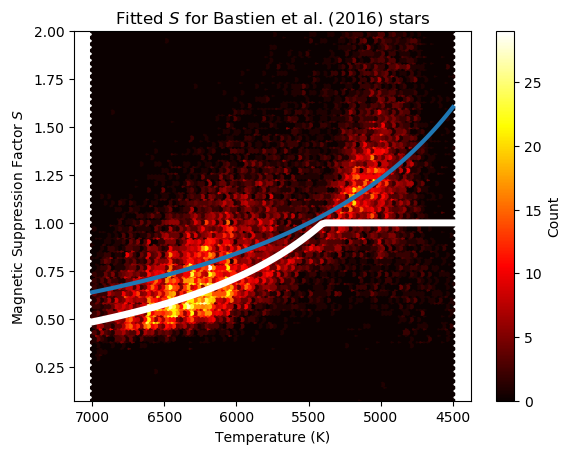

In [57]:
not_nan = np.isfinite(S_orig)
S = S_orig[not_nan]
temps = c['TeffH'][not_nan]
print("{} good values".format(np.sum(S > 0)))
print("{} bad values".format(np.sum(S <= 0) + np.sum(not_nan == False)))
print("{} total values".format(len(S_orig)))

popt, pcov = fit(temps, S)
perr = np.sqrt(np.diag(pcov))
print(f"Fit is 1 / (1 + (x - {popt[0]:.0f} +/- {perr[0]:.0f}) / {popt[1]:.0f} +/- {perr[1]:.0f})")
print("Steve had 1 / (1 + (x - 5400) / 1500)")

x = np.linspace(4500, 7000, 100)
y = calc_cranmer_S(x)
plt.plot(x, y, linewidth=5, color='white')
plt.hexbin(temps, S, cmap='hot')
plt.colorbar().set_label("Count")
plt.plot(x, f(x, *popt), color="C0", linewidth=3)
plt.gca().invert_xaxis()
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetic Suppression Factor $S$")
plt.title("Fitted $S$ for Bastien et al. (2016) stars");

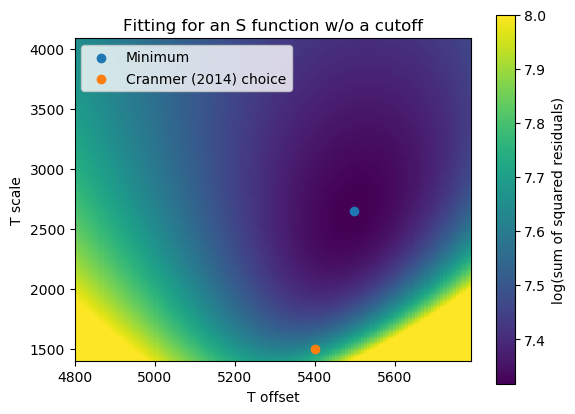

In [21]:
def h(Toff, Tscale):
    return np.sum((f(temps, Toff, Tscale) - S)**2)

Ts = []
sums = []
Toffs = range(4800, 5800, 8)
Tscales = range(1400, 4100, 10)
XX, YY = np.meshgrid(Toffs, Tscales)
vals = np.zeros_like(XX, dtype=np.float)

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        try:
            vals[i,j] = h(XX[i,j], YY[i,j])
        except:
            pass
plt.imshow(np.log(vals), extent=(XX.min(), XX.max(), YY.min(), YY.max()), aspect=.3, vmax=8.0, origin='lower')
plt.xlabel("T offset")
plt.ylabel("T scale")
plt.colorbar().set_label("log(sum of squared residuals)");
plt.scatter(*popt, label="Minimum")
plt.scatter(5400, 1500, label="Cranmer (2014) choice")
plt.legend(loc="upper left")
plt.title("Fitting for an S function w/o a cutoff");

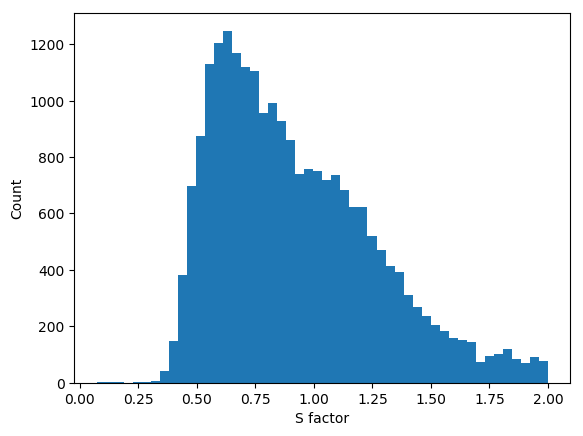

In [8]:
plt.hist(S, bins=50)
plt.xlabel("S factor")
plt.ylabel("Count");

That's all well and good, but S>1 isn't super physical, so just fitting S maybe isn't the best choice.

Hey, what if we force S<=1?

In [58]:
def f_clamped(x, Toff, Tscale):
    S = 1 / (1 + (x - Toff) / Tscale)
    S[S>1] = 1
    return S

def fit_clamped(x, y):
    return scp.optimize.curve_fit(f_clamped, x, y, p0=(5400, 1500))

Fit is 1 / (1 + (x - 5236 +/- 22) / 1905 +/- 55)
Steve had 1 / (1 + (x - 5400) / 1500)


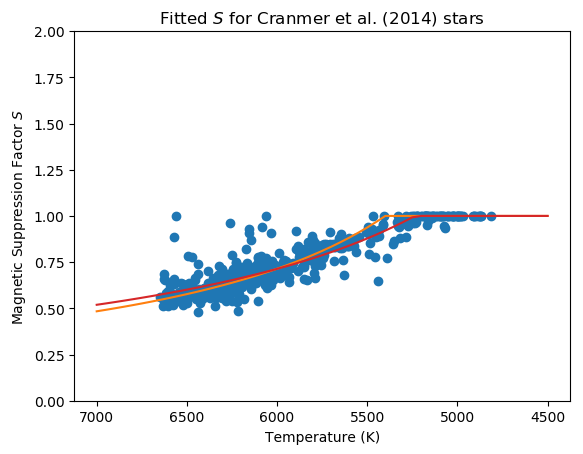

In [59]:
c = catalog[ catalog['has_C'] == 1 ]

S_cran = fit_S(c['loggC'], c['TeffC'], c['MC'], c['F8_obsC'], 1, 1)
scatter_x = c['TeffC']

popt, pcov = fit_clamped(scatter_x, S_cran)
perr = np.sqrt(np.diag(pcov))
print(f"Fit is 1 / (1 + (x - {popt[0]:.0f} +/- {perr[0]:.0f}) / {popt[1]:.0f} +/- {perr[1]:.0f})")
print("Steve had 1 / (1 + (x - 5400) / 1500)")

x = np.linspace(4500, 7000, 51)
y = calc_cranmer_S(x)
plt.scatter(scatter_x, S_cran)
plt.plot(x, y, color="C1")
plt.plot(x, f_clamped(x, *popt), color="C3")
plt.gca().invert_xaxis()
plt.ylim(0, 2)
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetic Suppression Factor $S$")
plt.title("Fitted $S$ for Cranmer et al. (2014) stars");

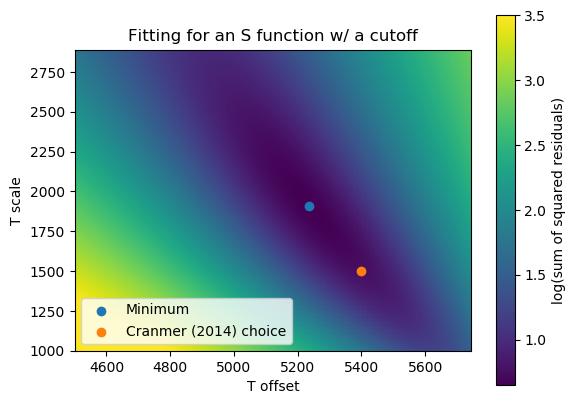

In [60]:
def g(Toff, Tscale):
    return np.sum((f_clamped(scatter_x, Toff, Tscale) - S_cran)**2)

Ts = []
sums = []
Toffs = range(4500, 5750, 5)
Tscales = range(1000, 2900, 10)
XX, YY = np.meshgrid(Toffs, Tscales)
vals = np.zeros_like(XX, dtype=np.float)

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        try:
            vals[i,j] = g(XX[i,j], YY[i,j])
        except:
            pass
plt.imshow(np.log(vals), extent=(XX.min(), XX.max(), YY.min(), YY.max()), aspect=.5, vmax=3.5, origin='lower')
plt.xlabel("T offset")
plt.ylabel("T scale")
plt.colorbar().set_label("log(sum of squared residuals)");
plt.scatter(*popt, label="Minimum")
plt.scatter(5400, 1500, label="Cranmer (2014) choice")
plt.legend(loc="lower left")
plt.title("Fitting for an S function w/ a cutoff");

In [47]:
c = catalog[ catalog['TeffH'] < 7000]

S_orig = fit_S(c['loggH'], c['TeffH'], c['MH'], c['F8'], 1, 1)

27248 good values
5 bad values
27253 total values
Fit is 1 / (1 + (x - 5264 +/- 9) / 2793 +/- 30)
Steve had 1 / (1 + (x - 5400) / 1500)


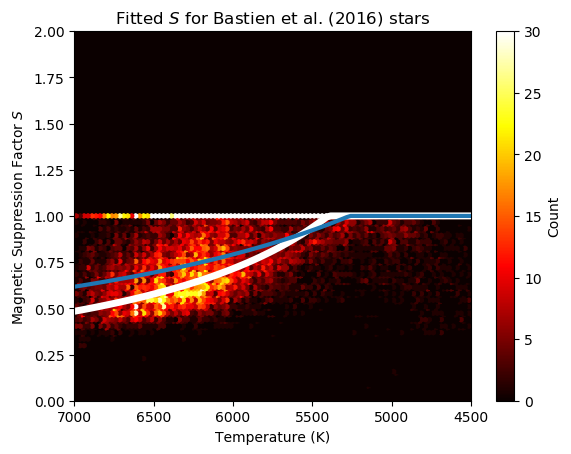

In [50]:
not_nan = np.isfinite(S_orig)
S = S_orig[not_nan]
temps = c['TeffH'][not_nan]
print("{} good values".format(np.sum(S > 0)))
print("{} bad values".format(np.sum(S <= 0) + np.sum(not_nan == False)))
print("{} total values".format(len(S_orig)))

popt, pcov = fit_clamped(temps, S)
perr = np.sqrt(np.diag(pcov))
print(f"Fit is 1 / (1 + (x - {popt[0]:.0f} +/- {perr[0]:.0f}) / {popt[1]:.0f} +/- {perr[1]:.0f})")
print("Steve had 1 / (1 + (x - 5400) / 1500)")

x = np.linspace(4500, 7000, 100)
y = calc_cranmer_S(x)
plt.ylim(0, 2)
plt.plot(x, y, linewidth=5, color='white')
plt.hexbin(temps, S, cmap='hot', extent=(4500, 7000, 0, 2), vmax=30)
plt.colorbar().set_label("Count")
plt.plot(x, f_clamped(x, *popt), color="C0", linewidth=3)
plt.gca().invert_xaxis()
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetic Suppression Factor $S$")
plt.title("Fitted $S$ for Bastien et al. (2016) stars");

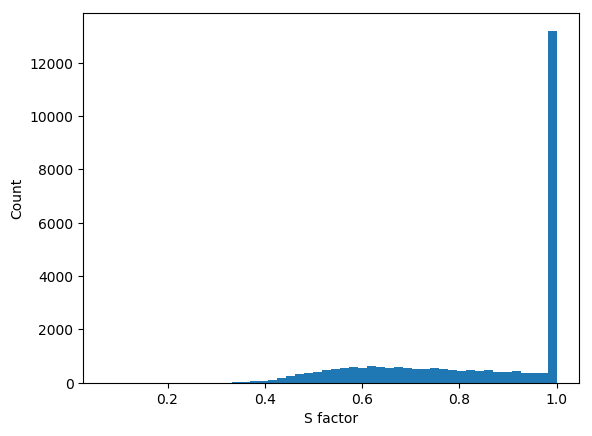

In [49]:
plt.hist(S, bins=50)
plt.xlabel("S factor")
plt.ylabel("Count");

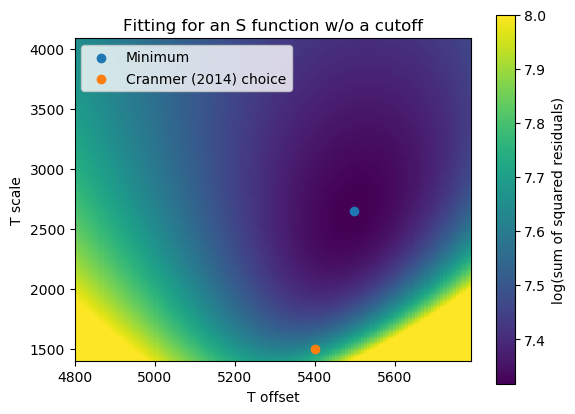

In [21]:
def h(Toff, Tscale):
    return np.sum((f(temps, Toff, Tscale) - S)**2)

Ts = []
sums = []
Toffs = range(4800, 5800, 8)
Tscales = range(1400, 4100, 10)
XX, YY = np.meshgrid(Toffs, Tscales)
vals = np.zeros_like(XX, dtype=np.float)

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        try:
            vals[i,j] = h(XX[i,j], YY[i,j])
        except:
            pass
plt.imshow(np.log(vals), extent=(XX.min(), XX.max(), YY.min(), YY.max()), aspect=.3, vmax=8.0, origin='lower')
plt.xlabel("T offset")
plt.ylabel("T scale")
plt.colorbar().set_label("log(sum of squared residuals)");
plt.scatter(*popt, label="Minimum")
plt.scatter(5400, 1500, label="Cranmer (2014) choice")
plt.legend(loc="upper left")
plt.title("Fitting for an S function w/o a cutoff");

Nothing astounding. The larger Bastien (2016) data set has a _lot_ of S>1 stars, which, again, aren't physical, so more is needed.